# Juntando as etapas descritas anteriormente em apenas duas partes: Forward Pass e BackPropagation

## Bibliotecas utilizadas:

In [319]:
## Libraries used
import math
import numpy as np
import random
from keras.datasets import mnist
import matplotlib.pyplot as plt


## Parte 0: Definição dos valores esperados para impulsos.

In [320]:
###########################################################################################
# A geração dos spike trains esperados para a rede neural, a priori, não é definido por um conjunto de valores fixos.
# Cada classe é representada por um array de 100 posições com valores inteiros, representando cada momento em que um spike foi gerado ou não.
# Para não criar um viés na definição e deixar o mais "randômico" possível, para cada classe esperada (0 a 9), serão geradas 
# sequências de valores aleatórios dentro de intervalos definidos para cada classe:
# Classe 0: Intervalo de valores inteiros de 0 a 9
# Classe 1: Intervalo de valores inteiros de 10 a 19
# Classe 2: Intervalo de valores inteiros de 20 a 29
# Classe 3: Intervalo de valores inteiros de 30 a 39
# Classe 4: Intervalo de valores inteiros de 40 a 49
# Classe 5: Intervalo de valores inteiros de 50 a 59
# Classe 6: Intervalo de valores inteiros de 60 a 69
# Classe 7: Intervalo de valores inteiros de 70 a 79
# Classe 8: Intervalo de valores inteiros de 80 a 89
# Classe 9: Intervalo de valores inteiros de 90 a 99
# Dessa forma a união dos intervalos vai corresponder ao intervalo completo de simulação, que no caso é de 100 passos ("ms")
def spike_interval_generator(number_of_classes=10, simulation_time=100, class_idx=-1):
    interval = []
    for i in range(number_of_classes):
        interval.append((i*int((simulation_time/number_of_classes)),-1 + ((i+1)*int((simulation_time/number_of_classes)))))
        
    if (class_idx >= 0): #Retorna apenas o intervalo correspondente da classe escolhida
        return interval[class_idx]
    
    return interval

###########################################################################################
## Spike Count Generator for Desired spikes
def spike_count_generator(number_of_classes=10, simulation_time=100, class_idx=-1):
    spike_counts_per_class = np.zeros(number_of_classes)
    
    for i in range(number_of_classes):
        spike_counts_per_class[i] = np.random.randint(0, number_of_classes)
        
    if (class_idx >= 0):#Retorna apenas as contagens correspondentes da classe escolhida
        return spike_counts_per_class[class_idx]
    
    return spike_counts_per_class

###########################################################################################
## Spike Times Generator for Desired spikes
def spike_times_generator(spike_range, spike_count, class_idx):
    desired_spike_times = []
    desired_spike_times = np.zeros((input_params['num_classes'], input_params['lif_simulation_time']))
    num_classes = input_params['num_classes']
    
    for i in range(num_classes):
        spike_time = random.sample(range(spike_range[i][0], spike_range[i][1]), int(spike_count[i]))
        desired_spike_times[i][spike_time] = 1
    
    if (class_idx >= 0):
        return  desired_spike_times[class_idx]
    
    return desired_spike_times

## Parte 1: Forward Pass. Corresponde a todas as etapas necessárias para mapear uma amostra no sinal de erro da rede neural.

In [321]:
###########################################################################################
## Image patches extraction
def patches_extraction(image, stride, patch_size):
    patches = []
    num_patches = 0
    ci = 0
    n = image.shape[1]
    while(ci < n):
        cj = 0
        while(cj < n):
            pivot = (ci, cj)
            if(pivot[0]+patch_size >= n or pivot[1]+patch_size >= n):
                cj += stride
            else:
                patch = image[pivot[0]:pivot[0]+patch_size, pivot[1]:pivot[1]+patch_size]
                patches.append(patch)
                num_patches += 1
                cj += stride
        ci += stride
    input_params['encoding_layer_neurons_num'] = num_patches
    return np.asarray(patches)

###########################################################################################
## Encoding Synaptic Current
def encoding_synaptic_current(patches, encoding_weights):
    num_patches = input_params['encoding_layer_neurons_num']
    synaptic_current = np.zeros(num_patches)
    patch_size = input_params['patch_size']
    for p in range(num_patches):
        acc = 0
        for i in range(patch_size):
            for j in range(patch_size):
                acc += (patches[p][i][j]*encoding_weights[p][i][j])/input_params['lif_enc_spike_current']
        synaptic_current[p] = acc
        
    input_params['encoding_current'] = synaptic_current
    #print(max(synaptic_current))
    return synaptic_current

###########################################################################################
## MLP Synaptic Current
def mlp_synaptic_current(encoding_spike_train, mlp_weights):
    synaptic_current = []
    for neuron in range(input_params['num_classes']):
        current = 0
        for u in range(input_params['encoding_layer_neurons_num']):
            for s in range(input_params['lif_simulation_time']):
                current += (encoding_spike_train[u][s] * mlp_weights[neuron][u][s])/input_params['lif_mlp_spike_current']
        synaptic_current.append(current)
    input_params['mlp_current'] = np.asarray(synaptic_current)
    return np.asarray(synaptic_current)

###########################################################################################
## LIF Neuron Potential Dynamics
def lif_activation(R, I, V_rest, V0, tao, t):
    return (V_rest+(R*I))+(V_rest-(R*I)-V0)*math.exp((-1*t)/(tao))


def integrate_and_fire_spikes(lif_R, lif_tao, lif_rest_voltage, lif_start_voltage, lif_threshold, I_syn, time_duration):
    spike_train = []
    spike_time = []
    spike_count = 0
    lif_timer = 0
    
    for t in range(time_duration):
        new_voltage = lif_activation(lif_R, I_syn, lif_rest_voltage, lif_start_voltage, lif_tao, lif_timer)
        #print('Membrane potential:', new_voltage)
        if (new_voltage >= lif_threshold):
            spike_train.append(1)
            spike_time.append(t)
            spike_count += 1
            lif_timer = 0
        else:
            spike_train.append(0)
            lif_timer += 1
            
    return np.asarray(spike_train), np.asarray(spike_time), spike_count

###########################################################################################
## Spikes Generation
def spikes_generation(layer_name, input_current, neuron_resistance, time_constant, rest_potential, start_potential, threshold, simulation_time):
    st = []
    st_times = []
    st_count = []

    if(layer_name == 'mlp'):
        iteration_set = input_params['num_classes']
        spike_train_param = 'mlp_spikes'
        spike_time_param  = 'mlp_spike_times'
        spike_count_param = 'mlp_spike_count'
    else: # 'encoding'
        iteration_set = input_params['encoding_layer_neurons_num']
        spike_train_param = 'encoding_spikes'
        spike_time_param  = 'encoding_spike_times'
        spike_count_param = 'encoding_spike_count'
    
    for neuron in range(iteration_set):
        spikes, spike_times, spike_count = integrate_and_fire_spikes(lif_R=neuron_resistance, 
                                                                        lif_tao=time_constant,
                                                                        lif_rest_voltage=rest_potential, 
                                                                        lif_start_voltage=start_potential, 
                                                                        lif_threshold=threshold, 
                                                                        I_syn=input_current[neuron], 
                                                                        time_duration=simulation_time)
        st.append(spikes)
        st_times.append(spike_times)
        st_count.append(spike_count)

    st = np.asarray(st)
    st_times = np.asarray(st_times)
    st_count = np.asarray(st_count)

    input_params[spike_train_param] = st
    input_params[spike_time_param] = st_times
    input_params[spike_count_param] = st_count
    
    return st, st_times, st_count

###########################################################################################
## Error signal Evaluation
def evaluate_error_signal(desired_spikes, model_spikes):
    return desired_spikes - model_spikes

###########################################################################################
## Instantaneous error energy value
def error_energy_value(error_signal):
    sqr_error = 0
    for k in range(input_params['num_classes']):
        for t in range(input_params['lif_simulation_time']):
            sqr_error += (error_signal[k][t])**2
    return 0.5*sqr_error

3


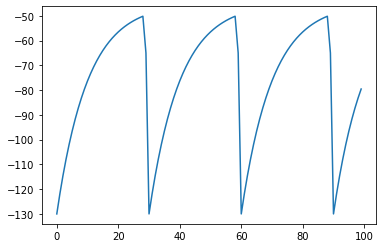

In [322]:
# Analise do potencial da membrana
spike_train = []
spike_time = []
spike_count = 0

I_syn = np.zeros(100)
potential = []

I = 2

for i in range(100):
    I_syn[i] = I

timer = 0
for t in range(100):
   vt = lif_activation(10, I_syn[i], -65, 0, 10, timer)
   if (vt >= -50):
       vt = -65
       timer = 0
       potential.append(vt)
       spike_train.append(1)
       spike_time.append(t)
       spike_count += 1
   else:
       spike_train.append(0)
       potential.append(vt)
       timer += 1
    
potential = np.asarray(potential)
print(spike_count)
plt.plot(potential)


## Parte 1.1: Função Forward Pass. 

In [323]:
###########################################################################################
## Forward Pass Main Function. It maps one sample from the set into the error_signal and 
## error energy.
def forwardPass(input_sample, encoding_weights, mlp_weights):
    patches = patches_extraction(input_sample, patch_size=input_params['patch_size'], stride=input_params['stride'])
    encoding_current = encoding_synaptic_current(patches, encoding_weights)
    encoding_st, encoding_st_times, encoding_st_count = spikes_generation(layer_name='encoding', input_current=encoding_current,
                                                                          neuron_resistance=input_params['lif_enc_resistance'], 
                                                                          time_constant=input_params['lif_enc_tao'], 
                                                                          rest_potential=input_params['lif_enc_rest_potential'], 
                                                                          start_potential=input_params['lif_enc_start_potential'],
                                                                          threshold=input_params['lif_enc_threshold'], 
                                                                          simulation_time=input_params['lif_simulation_time'])
    mlp_current = mlp_synaptic_current(encoding_st, mlp_weights)
    mlp_st, mlp_st_times, mlp_st_count = spikes_generation(layer_name='mlp', input_current=mlp_current,
                                                                          neuron_resistance=input_params['lif_mlp_resistance'], 
                                                                          time_constant=input_params['lif_mlp_tao'], 
                                                                          rest_potential=input_params['lif_mlp_rest_potential'], 
                                                                          start_potential=input_params['lif_mlp_start_potential'],
                                                                          threshold=input_params['lif_mlp_threshold'], 
                                                                          simulation_time=input_params['lif_simulation_time'])
    error_signal = evaluate_error_signal(input_params['desired_spikes'], mlp_st)
    error_energy = error_energy_value(error_signal)
    return error_signal, error_energy, encoding_current, mlp_current

## Parte 2: Backward Pass: Backpropagation. Corresponde a todas as etapas que usam o sinal de erro para promover os ajustes de pesos sinápticos

In [324]:
###########################################################################################
## LIF Activation Derivative
def lif_activation_derivative(R, I, V_rest, V0, tao, t):
    return ((V_rest+(R*I)+V0)*math.exp((-1*t)/(tao)))/tao  

###########################################################################################
## MLP Local Gradient Evaluation
def mlp_local_gradient(sample_error_signal, mlp_current):
    local_gradient = np.zeros((input_params['num_classes'], input_params['lif_simulation_time']))
    for k in range(input_params['num_classes']):
        for t in range(input_params['lif_simulation_time']):
            local_gradient[k][t] = (-1)*sample_error_signal[k][t]*lif_activation_derivative(R     = input_params['lif_mlp_resistance'],
                                                                                            I     = mlp_current[k], 
                                                                                            V_rest= input_params['lif_mlp_rest_potential'], 
                                                                                            V0    = input_params['lif_mlp_start_potential'], 
                                                                                            tao   = input_params['lif_mlp_tao'], 
                                                                                            t     = t)
    return local_gradient

###########################################################################################
## Encoding Local Gradient Evaluation
def enc_local_gradient(mlp_gradients, mlp_weights, encoding_current):
    local_gradient = np.zeros((input_params['encoding_layer_neurons_num']))
    for e in range(input_params['encoding_layer_neurons_num']):
        acc = 0
        for k in range(input_params['num_classes']):
            for t in range(input_params['lif_simulation_time']):
                acc += mlp_gradients[k][t]*mlp_weights[k][e][t]
        local_gradient[e] = acc*lif_activation_derivative(R      = input_params['lif_enc_resistance'],
                                                          I      = encoding_current[e], 
                                                          V_rest = input_params['lif_enc_rest_potential'], 
                                                          V0     = input_params['lif_enc_start_potential'], 
                                                          tao    = input_params['lif_enc_tao'], 
                                                          t      = t)
    return local_gradient

###########################################################################################
## Delta Rule for MLP Layer
def mlp_delta_rule(mlp_gradient, mlp_output):
    return input_params['learning_rate']*mlp_gradient*mlp_output

###########################################################################################
## Delta Rule for Encoding Layer
def encoding_delta_rule(encoding_gradient, encoding_output):
    delta = []
    for d in range(input_params['encoding_layer_neurons_num']):
        delta.append(input_params['learning_rate']*encoding_gradient[d]*encoding_output[d])
    return np.asarray(delta)

###########################################################################################
## Compute New Weights for MLP Layer
def compute_new_mlp_weights(mlp_weights, delta):
    new_weights = []
    for d in range(input_params['encoding_layer_neurons_num']):
        new_weights.append(mlp_weights[:, d]+delta)
    return np.reshape(np.asarray(new_weights), (input_params['num_classes'], input_params['encoding_layer_neurons_num'], input_params['lif_simulation_time']))

###########################################################################################
## Compute New Weights for Encoding Layer
def compute_new_enc_weights(enc_weights, delta):
    new_weights = []
    for d in range(input_params['encoding_layer_neurons_num']):
        new_weights.append(enc_weights[d]+delta[d])
    return np.asarray(new_weights)


## Parte 2.1: Função de Backpropagation

In [325]:
###########################################################################################
## Backpropagation function. It uses the error signal and energy to provide new synaptic
## weights adjustments.
def spike_backpropagation(error_signal, encoding_current, mlp_current):
    mlp_local_grad = mlp_local_gradient(error_signal, mlp_current)
    enc_local_grad = enc_local_gradient(mlp_local_grad, input_params['mlp_weights'], encoding_current)
    mlp_delta = mlp_delta_rule(mlp_local_grad, input_params['mlp_spikes'])
    enc_delta = encoding_delta_rule(enc_local_grad, input_params['encoding_spike_count'])
    new_mlp_W = compute_new_mlp_weights(input_params['mlp_weights'], mlp_delta)
    new_enc_W = compute_new_enc_weights(input_params['encoding_weights'], enc_delta)
    return new_mlp_W, new_enc_W

# Execução do bloco principal do algoritmo de treinamento:

## Definição de parâmetros utilizados pela SNN:

In [326]:
## Definition of a set of parameters that will be used for analysis and code recycling too.
input_params = {}

In [331]:
# Image Patch size
input_params['patch_size'] = 5
input_params['stride'] = 1
input_params['patches_set'] = 529

# Time duration for spikes generation on LIF neurons
input_params['lif_simulation_time'] = 100

# Biological parameters for Encoding and MLP Lif Neurons
input_params['lif_enc_resistance'] = 10
input_params['lif_enc_tao'] = 10
input_params['lif_enc_threshold'] = -50
input_params['lif_enc_rest_potential'] = -65
input_params['lif_enc_start_potential'] = 0
input_params['lif_enc_spike_current'] = 10*(input_params['lif_enc_threshold']-input_params['lif_enc_rest_potential'])/input_params['lif_enc_resistance']

input_params['lif_mlp_resistance'] = 10
input_params['lif_mlp_tao'] = 10
input_params['lif_mlp_threshold'] = -50
input_params['lif_mlp_rest_potential'] = -65
input_params['lif_mlp_start_potential'] = 0
input_params['lif_mlp_spike_current'] = 10*(input_params['lif_mlp_threshold']-input_params['lif_mlp_rest_potential'])/input_params['lif_mlp_resistance']

# Output size
input_params['num_classes'] = 10

# Backpropagation hyperparameters
input_params['learning_rate'] = 1
input_params['num_epochs'] = 16
input_params['num_samples'] = 1


## Execução para apenas uma amostra aleatória de uma classe aleatória

In [332]:
## Extração das amostras
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255

# Escolhe um range aleatório de labels de acordo com sua quantidade
labels = random.sample(range(0,input_params['num_classes']), input_params['num_classes'])
samples = []

# Monta um array com samples por label
for label in labels:
    samples_per_label = x_train[np.where(y_train == label)]
    num_samples_per_label = samples_per_label.shape[0]
    samples_idx = random.sample(range(0, num_samples_per_label-1), input_params['num_samples'])
    samples.append(samples_per_label[samples_idx])

samples = np.asarray(samples)
print(samples.shape)

(10, 1, 28, 28)


## Geração dos Impulsos Desejados para a(s) classe(s) definida(s):

In [333]:
# Expected Values for Spikes for 1 class
desired_range = spike_interval_generator(simulation_time=input_params['lif_simulation_time'])
desired_count = spike_count_generator(simulation_time=input_params['lif_simulation_time'])
dsp = spike_times_generator(desired_range, desired_count, -1)
input_params['desired_spikes'] = dsp[labels]
print(input_params['desired_spikes'].shape)

(10, 100)


MSE Error: 23.5
MSE Error: 23.5
MSE Error: 23.5
MSE Error: 23.5
MSE Error: 23.5
MSE Error: 23.5
MSE Error: 23.5
MSE Error: 23.5
MSE Error: 23.5
MSE Error: 23.5
MSE Error: 23.5
MSE Error: 23.5
MSE Error: 23.5
MSE Error: 23.5
MSE Error: 23.5
MSE Error: 23.5


Text(0, 0.5, 'MSE Absolute')

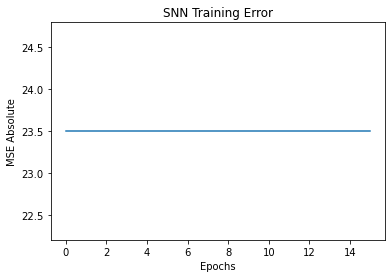

In [334]:
# Synaptic Weights Initialization
W_enc = np.random.uniform(0, 1, (input_params['patches_set'], input_params['patch_size'], input_params['patch_size']))
input_params['encoding_weights'] = W_enc

W_mlp = np.random.uniform(0, 1, (input_params['num_classes'], input_params['patches_set'], input_params['lif_simulation_time']))
input_params['mlp_weights'] = W_mlp

training_error = []
epoch_count = 0
while(epoch_count < input_params['num_epochs']):
    class_count = 0
    err_sum = 0
    while(class_count < input_params['num_classes']):
        sample_count = 0
        while(sample_count < input_params['num_samples']):
            error_signal, error_energy, I_enc, I_mlp = forwardPass(input_sample=samples[class_count, sample_count], 
                                                                   encoding_weights=input_params['encoding_weights'], 
                                                                   mlp_weights=input_params['mlp_weights'])
            mw, ew = spike_backpropagation(error_signal, I_enc, I_mlp)
            input_params['mlp_weights'] = mw
            input_params['encoding_weights'] = ew
            err_sum += error_energy
            sample_count += 1
        class_count += 1
    epoch_count += 1
    mse = err_sum/(input_params['num_classes']*input_params['num_samples'])
    print('MSE Error: {}'.format(mse))
    training_error.append(mse)
training_error = np.asarray(training_error)
plt.plot(training_error)
plt.title("SNN Training Error")
plt.xlabel('Epochs')
plt.ylabel('MSE Absolute')
